In [13]:
import os
import random
from datetime import datetime
import ast
import math

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from preprocessing.final_preprocessing import serve_data_unet

from models.context_unet import ContextUnet

import ddpm.cu_ddpm as ddpm

from evaluation.pca_tsne import visualize_all_customers, visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [14]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [15]:
config_path = "./config_unet.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])
img_rows = int(config["img_rows"])
img_cols = int(config["img_cols"])
channels = int(config["channels"])
n_feat = int(config["n_feat"])

assert model_name in ["ContextUnet"], "Chosen  model was not valid, the option is ContextUnet"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [16]:
#Can take a while to load
train_loader, test_loader, n_cfeat, customer_ids, train_data, test_data = serve_data_unet(batch_size=batch_size_config)

# Model

In [17]:
model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=img_cols, cond_model=cond_model).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(tb_writer)

## DDPM

# Train

In [18]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

model.train()
for ep in tqdm(range(epochs)):
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lr*(1-ep/epochs)
    epoch_loss = 0.0   # initialize epoch loss
    for i, (x, c) in enumerate(train_loader):   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        noise = noise.type(torch.float32)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = ddpm.perturb_input(x, t, noise, beta1=betas[0], beta2=betas[1], timesteps=timesteps, device=device)

        # use network to recover noise
        time = t / timesteps
        time = time.type(torch.float32)
        x_pert = x_pert.type(torch.float32)
        c = c.type(torch.float32)
        
        pred_noise = model(x_pert, time, c=c)
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
        
        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, ep)
    
    if ep % 5 ==0:        
        sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size_config, context=None, channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
        
        p = sample.repeat(1, 3, 1, 1).cpu()
        q = torch.from_numpy(test_data[:batch_size_config]).repeat(1, 3, 1, 1) 
        
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)   
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, ep)
        
        print(f'Epoch: {ep+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse(p,q):.4f}')
    
    else:
        print(f'Epoch: {ep+1}, Epoch Loss: {avg_epoch_loss:.4f}')
        
    if ep % save_rate == 0:
        torch.save({
            'epoch': ep+1,
            'diffusion_state_dict': model.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{ep}_mse_{avg_epoch_loss:.3f}_weights.pth'))
    
torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Epoch Loss: 0.4145, RMSE: 5.1101


100%|██████████| 1/1 [02:33<00:00, 153.17s/it]


# Sampling

In [19]:
def plot_samples(sample, rows=None, cols=None, figsize=(12, 10), title=None):
    n_images = sample.shape[0]
    
    if rows is None and cols is None:
        cols = math.ceil(math.sqrt(n_images))
        rows = math.ceil(n_images / cols)
    elif rows is None:
        rows = math.ceil(n_images / cols)
    elif cols is None:
        cols = math.ceil(n_images / rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    if rows > 1 or cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  
    
    for i in range(n_images):
        if i < len(axes):  
            im = axes[i].imshow(sample[i], cmap='viridis')
            axes[i].set_title(f'Image {i+1}')
            axes[i].axis('off')  
    
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [20]:
sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size_config, context=None, channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])

In [21]:
sample = sample.cpu().numpy()
sample = sample.squeeze()

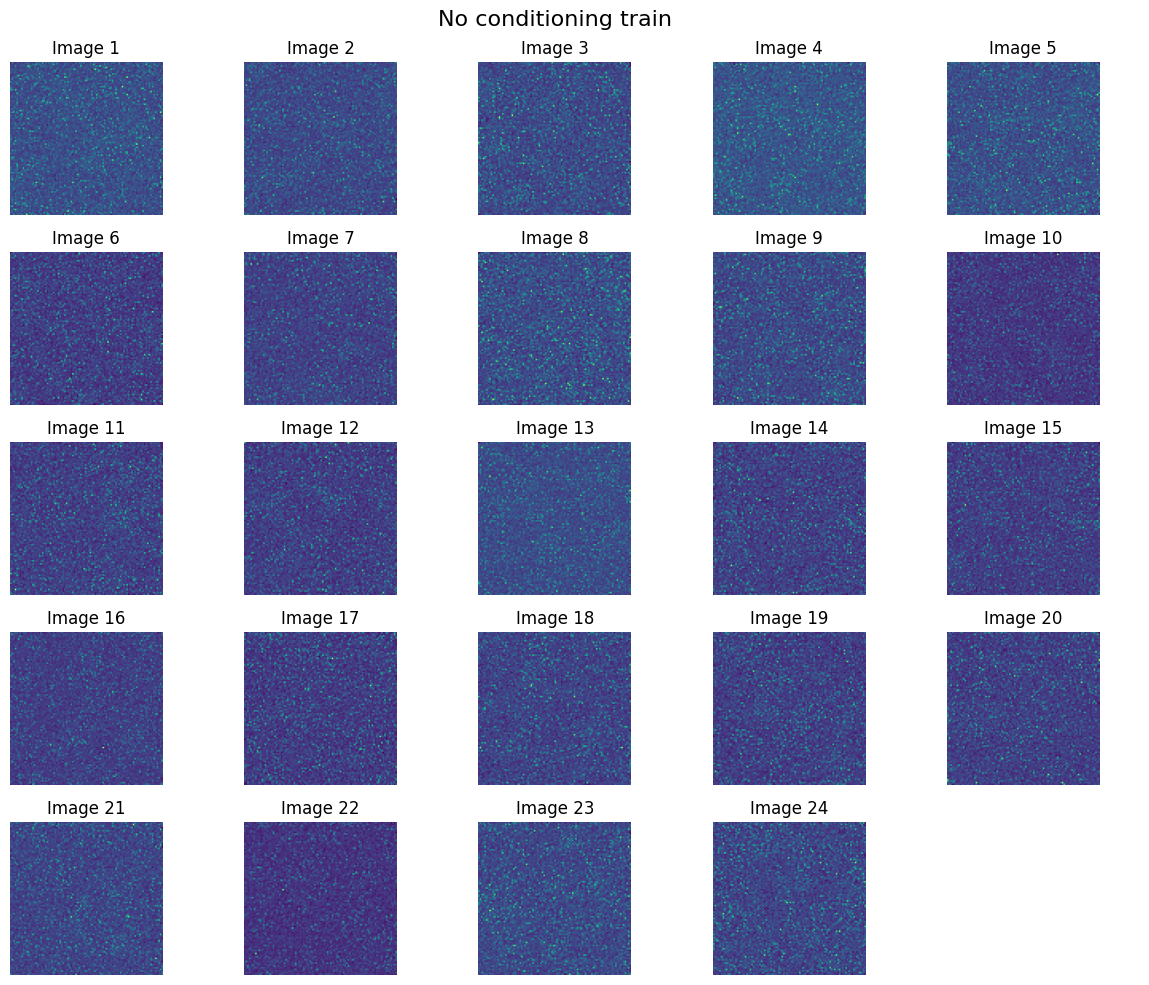

In [22]:
plot_samples(sample, title="No conditioning train")

# Evaluation
## Without Conditioning
### Train

In [23]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

ts_sample = np.expand_dims(sample.reshape(batch_size_config, -1), -1).transpose(2,1,0)
ts_train = np.expand_dims(real_data_train.reshape(batch_size_config, -1), -1).transpose(2,1,0)
ts_test = np.expand_dims(real_data_test.reshape(batch_size_config, -1), -1).transpose(2,1,0)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


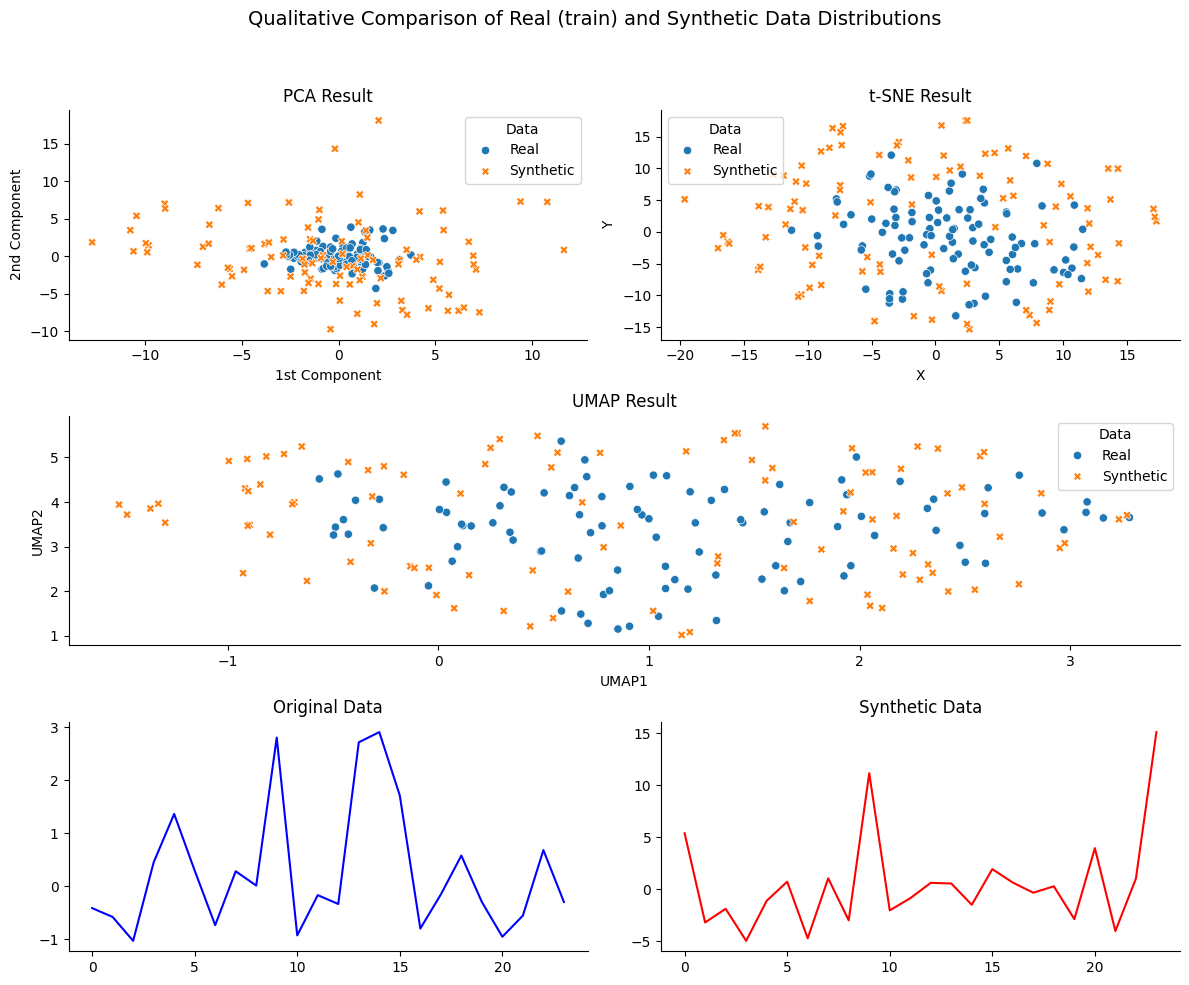

In [24]:
visualize_all_customers(ori_data=ts_train, sample=ts_sample, seq_len=batch_size_config, filename=log_file_name, cond=False, train_test="train", batch_size=1, num_customers=100)

### Test

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


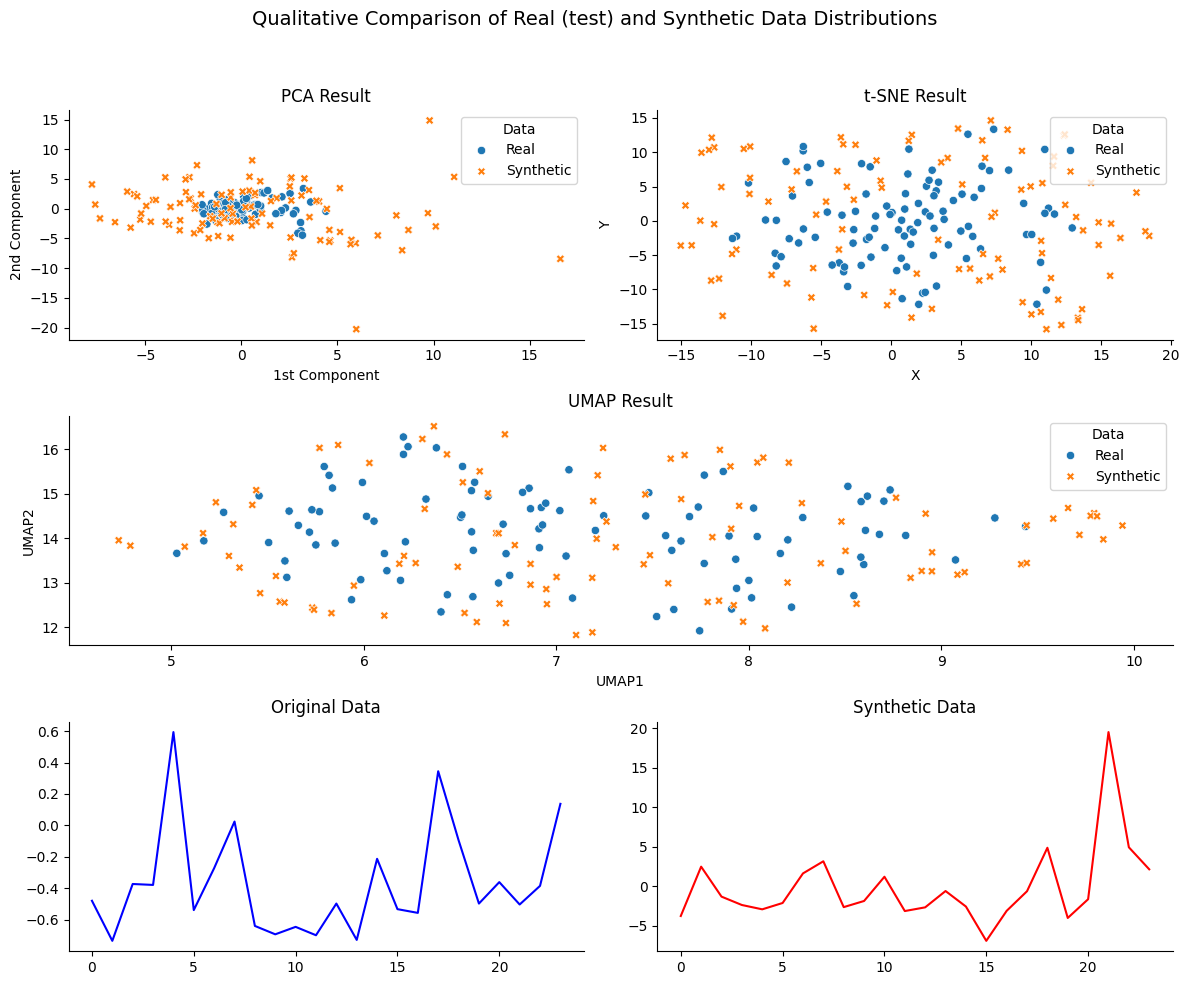

In [25]:
visualize_all_customers(ori_data=ts_test, sample=ts_sample, seq_len=batch_size_config, filename=log_file_name, cond=False, train_test="test", batch_size=1, num_customers=100)

### JSD

In [27]:
jsd_train = np.expand_dims(real_data_train.reshape(batch_size_config, -1), -1)
jsd_test = np.expand_dims(real_data_test.reshape(batch_size_config, -1), -1)

plot_jsd(jsd_train, jsd_test, ts_sample, log_file_name, cond=False)

IndexError: index 24 is out of bounds for axis 2 with size 24

## With Conditioning
### Train

In [ ]:
real_cond_data_train = real_cond_data_train.to(torch.float32)
sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size_config, context=real_cond_data_train.to(device), channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
sample = sample.cpu().numpy()
sample = sample.squeeze()
ts_sample = np.expand_dims(sample.reshape(batch_size_config, -1), -1).transpose(2,1,0)

In [ ]:
visualize_all_customers(ori_data=ts_train, sample=ts_sample, seq_len=batch_size_config, filename=log_file_name, cond=True, train_test="train", batch_size=1, num_customers=100)

### JSD

In [ ]:
plot_jsd(jsd_train, jsd_test, ts_sample, log_file_name, cond=True)

### Test

In [ ]:
real_cond_data_test = real_cond_data_test.to(torch.float32)
sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size_config, context=real_cond_data_test.to(device), channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
sample = sample.cpu().numpy()
sample = sample.squeeze()
ts_sample = np.expand_dims(sample.reshape(batch_size_config, -1), -1).transpose(2,1,0)


In [ ]:
visualize_all_customers(ori_data=ts_train, sample=ts_sample, seq_len=batch_size_config, filename=log_file_name, cond=True, train_test="test", batch_size=1, num_customers=100)

### JSD

In [ ]:
plot_jsd(jsd_train, jsd_test, ts_sample, log_file_name, cond=True)

In [ ]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\n\nRMSE Values:\n")
    for rmse in rmse_list:
        log_file.write(f"{rmse}\n")

print(f"Log file created at: {log_file_path}")